# Imports and Preparing the data of behavior.tsv and news.tsv #

In [1]:
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
from sklearn.metrics import silhouette_score
import numpy as np
import pandas as pd
import re
from pathlib import Path
from sklearn.feature_extraction.text import TfidfVectorizer
from scipy.sparse import hstack
from sklearn.decomposition import IncrementalPCA, PCA
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE


# Load the data
base_path = Path.cwd() / 'data'
news_path = base_path / 'news.tsv'
behaviors_path = base_path / 'behaviors.tsv'

news = pd.read_csv(news_path, sep='\t', names=['news_id', 'category', 'subcategory', 'title', 'abstract', 'url', 'title_entities', 'abstract_entities'])
behaviors = pd.read_csv(behaviors_path, sep='\t', names=['impression_id', 'user_id', 'time', 'history', 'impressions'])

# Preprocessing with Data Cleaning Remove duplicates and Text cleaning

In [2]:
# Data Cleaning
# Check if attributes such as Category, Subcategory, Title, and Abstract in news.tsv are complete.
# Remove news items with many missing values or replace them with:
# Category: unknown
# Subcategory: general
# Title and Abstract: a placeholder text like "Missing Data."
# For behaviors.tsv, remove users with missing or empty history.
news.fillna({'category': 'unknown', 'subcategory': 'general', 'title': 'Missing Title', 'abstract': 'Missing Abstract'}, inplace=True)
news.dropna(subset=['category', 'subcategory', 'title', 'abstract'], inplace=True)
behaviors.dropna(subset=['history', 'impressions'], inplace=True)

# Remove duplicates
# Remove news items in news.tsv that have the same values for Title and Abstract.
# Remove duplicate impressions (Impression ID) in behaviors.tsv
news.drop_duplicates(subset=['title', 'abstract'], inplace=True)
behaviors.drop_duplicates(subset=['impression_id'], inplace=True)

# Text cleaning
# Break down Title and Abstract into tokens:
# Remove special characters, numbers, and HTML.
# Convert all words to lowercase.
# Remove stopwords (e.g., using nltk or spacy).
# Perform lemmatization to reduce words to their base form.
def clean_text(text):
    """Clean text by removing special characters, numbers, and converting to lowercase."""
    text = re.sub(r"n't", " not", text)
    text = re.sub(r"'ll", " will", text)
    text = re.sub(r"'ve", " have", text)
    text = re.sub(r"'re", " are", text)
    text = re.sub(r"'d", " would", text)
    text = re.sub(r"'s", " is", text)
    
    text = re.sub(r'\W+', ' ', text)  # Remove special characters
    text = re.sub(r'\d+', '', text)  # Remove numbers
    return text.lower()

def remove_stopwords_and_lemmatize(text):
    """Remove stopwords and perform basic stemming/lemmatization."""
    stopwords = set([
        'the', 'and', 'is', 'in', 'to', 'of', 'a', 'an', 'on', 'for', 'with', 'as', 'by', 'at', 'from', 'this',
        'that', 'it', 'or', 'but', 'not', 'be', 'are', 'was', 'were', 'can', 'will', 'would', 'should', 'has', 'have',
        'had', 'do', 'does', 'did', 'which', 'if', 'then', 'than', 'so', 'such', 'there', 'about', 'into', 'over', 'after'
    ])
    words = text.split()
    # Basic lemmatization (remove plural "s")
    lemmatized = [word[:-1] if word.endswith('s') else word for word in words]  
    return " ".join(word for word in lemmatized if word not in stopwords)

def preprocess_text(text):
    """Full preprocessing pipeline: clean text, remove stopwords, and lemmatize."""
    cleaned_text = clean_text(text)
    return remove_stopwords_and_lemmatize(cleaned_text)

def preprocess_text_parallel(texts):
    processed_texts = [preprocess_text(text) for text in texts]
    return processed_texts

# Clean Title and Abstract
news['clean_title'] = preprocess_text_parallel(news['title'])
news['clean_abstract'] = preprocess_text_parallel(news['abstract'])

# Data Preparation with TF-IDF, One-hot and PCA

In [3]:
#TF-IDF
# Convert clean_title and clean_abstract into numerical vectors
tfidf_vectorizer = TfidfVectorizer(max_features=500)
tfidf_title = tfidf_vectorizer.fit_transform(news['clean_title'])
tfidf_abstract = tfidf_vectorizer.fit_transform(news['clean_abstract'])

# Combine sparse matrices
news_features = hstack([tfidf_title, tfidf_abstract])

# One-hot encode categories and subcategories
category_encoded = pd.get_dummies(news['category'])
subcategory_encoded = pd.get_dummies(news['subcategory'])

# Combine categorical and TF-IDF features
final_features = hstack([news_features, category_encoded.values, subcategory_encoded.values])

# PCA for faster processing instead of t-SNE for better visualization
pca = IncrementalPCA(n_components=50, batch_size=1000)
reduced_features = pca.fit_transform(news_features)

# Elbow method to get best cluster amount

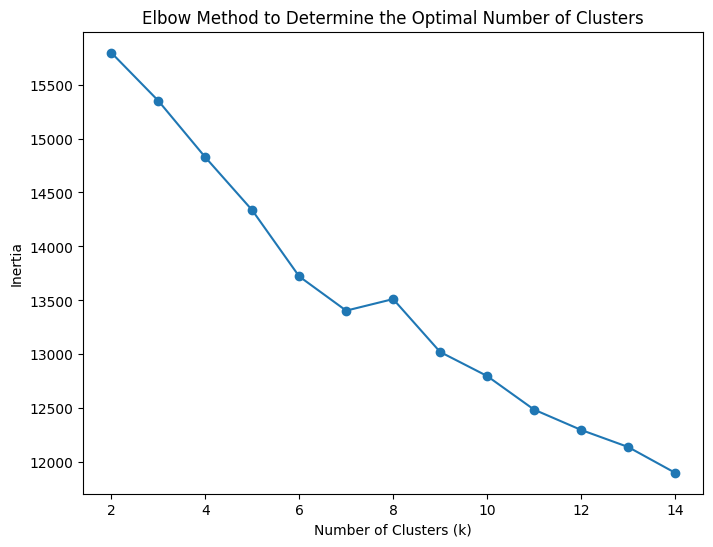

In [4]:
# Elbow method
inertia_values = []
cluster_range = range(2, 15)  # Test cluster numbers between 2 and 14

for k in cluster_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(reduced_features)
    inertia_values.append(kmeans.inertia_)

# Elbow Method
plt.figure(figsize=(8, 6))
plt.plot(cluster_range, inertia_values, marker='o')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia')
plt.title('Elbow Method to Determine the Optimal Number of Clusters')
plt.show()

# Silhouette analysis to get best cluster amount

In [ ]:
# Silhouette analysis
silhouette_scores = []

for k in cluster_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    labels = kmeans.fit_predict(reduced_features)
    silhouette_avg = silhouette_score(reduced_features, labels)
    silhouette_scores.append(silhouette_avg)

plt.figure(figsize=(8, 6))
plt.plot(cluster_range, silhouette_scores, marker='o', color='orange')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Average Silhouette Score')
plt.title('Silhouette Analysis to Determine the Optimal Number of Clusters')
plt.show()

# Hierarchical Clustering with Dendrogram

In [ ]:
optimal_k = 6

agglo = AgglomerativeClustering(n_clusters=optimal_k, linkage='ward')
labels = agglo.fit_predict(reduced_features)

# 10. PCA for Visualization of Clusters (Agglomerative Clustering)
pca_vis = PCA(n_components=2)
pca_features = pca_vis.fit_transform(reduced_features)

# Plot PCA visualization
plt.figure(figsize=(10, 7))
plt.scatter(pca_features[:, 0], pca_features[:, 1], c=labels, cmap='viridis', s=10)
plt.title(f'PCA Visualization with AgglomerativeClustering Clusters')
plt.show()

# If you still want a dendrogram like in scipy, you can visualize the clustering results
# by creating a dendrogram based on AgglomerativeClustering distances:
from scipy.cluster.hierarchy import dendrogram, linkage
Z = linkage(reduced_features, 'ward')
plt.figure(figsize=(10, 7))
dendrogram(Z)
plt.title('Dendrogram based on Agglomerative Clustering')
plt.show()

# KMeans Visualization with PCA

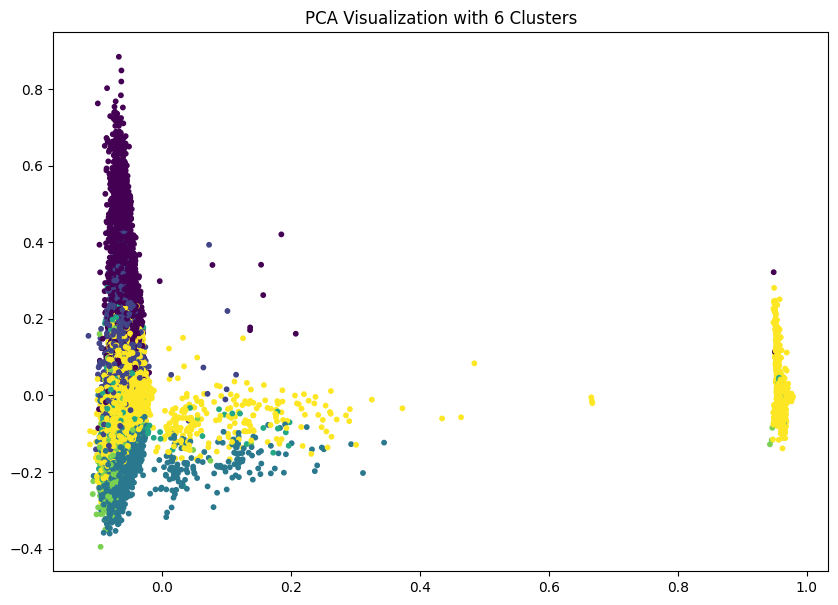

In [29]:
# Clustering with MiniBatchKMeans
optimal_k = 6

kmeans = KMeans(n_clusters=optimal_k, random_state=42)
news['cluster'] = kmeans.fit_predict(reduced_features)

# PCA for Visualization
pca_vis = IncrementalPCA(n_components=2)
pca_features = pca_vis.fit_transform(reduced_features)

# PCA Visualization
plt.figure(figsize=(10, 7))
plt.scatter(pca_features[:, 0], pca_features[:, 1], c=news['cluster'], cmap='viridis', s=10)
plt.title(f'PCA Visualization with {optimal_k} Clusters (KMeans)')
plt.show()


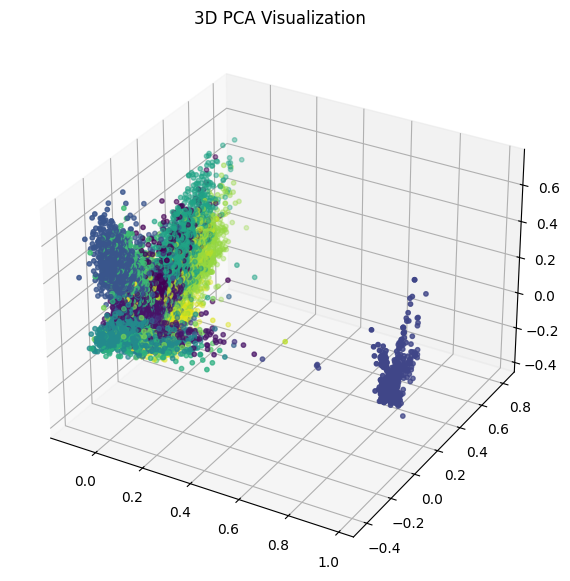

In [22]:
# PCA mit 3 Dimensionen
pca_3d = IncrementalPCA(n_components=3)
pca_features_3d = pca_3d.fit_transform(reduced_features)

# 3D-Visualisierung
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')
scatter = ax.scatter(
    pca_features_3d[:, 0], 
    pca_features_3d[:, 1], 
    pca_features_3d[:, 2], 
    c=news['cluster'], cmap='viridis', s=10
)

ax.set_title('3D PCA Visualization (KMeans)')
plt.show()


C:\Users\stefa\PycharmProjects\CTDS\venv\Lib\site-packages\sklearn\manifold\_t_sne.py:1162: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


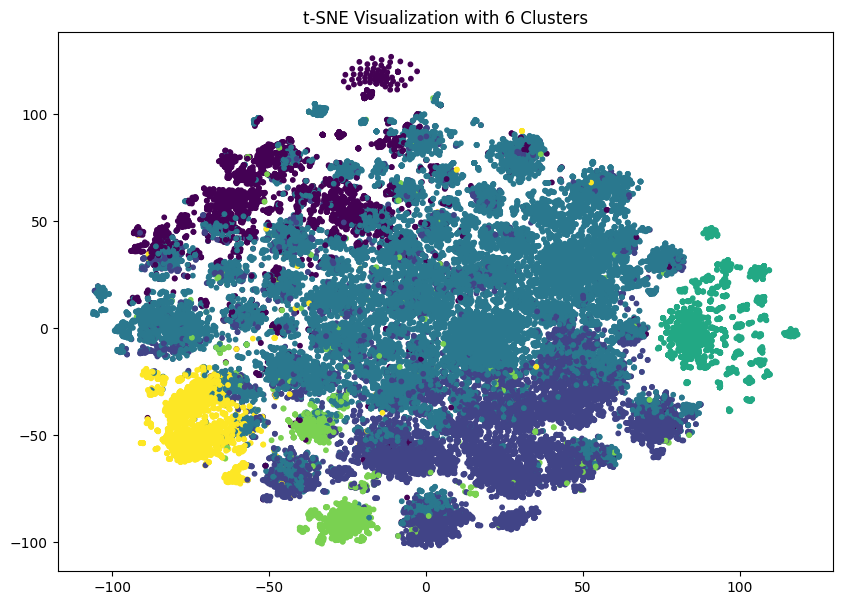

In [15]:
# t-SNE Transformation
tsne = TSNE(n_components=2, random_state=42, perplexity=30, n_iter=1000)
tsne_features = tsne.fit_transform(reduced_features)

# t-SNE Visualization
plt.figure(figsize=(10, 7))
plt.scatter(tsne_features[:, 0], tsne_features[:, 1], c=news['cluster'], cmap='viridis', s=10)
plt.title(f't-SNE Visualization with {optimal_k} Clusters')
plt.show()


# DBSCAN Clustering

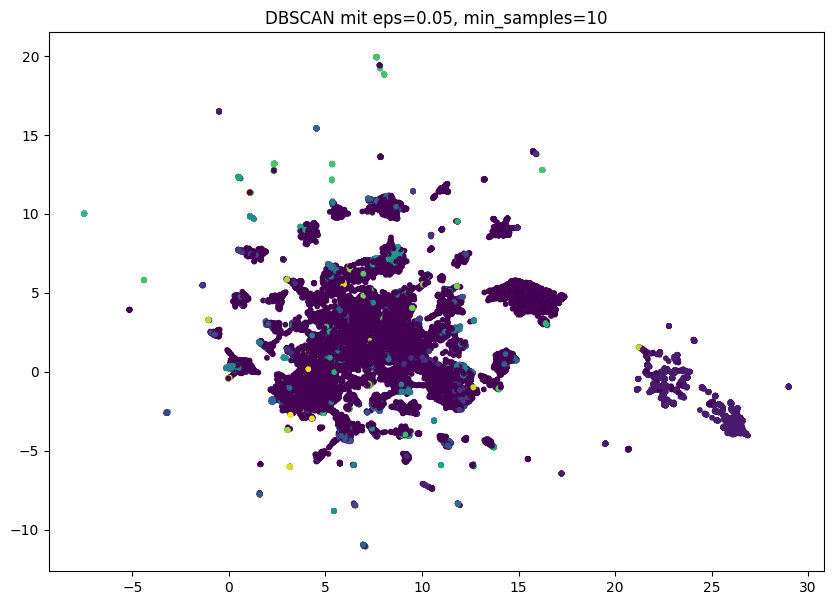

Parameter eps=0.05, min_samples=10
{-1: 38174, 0: 1291, 1: 88, 2: 31, 3: 48, 4: 79, 5: 86, 6: 40, 7: 2506, 8: 81, 9: 101, 10: 167, 11: 12, 12: 47, 13: 22, 14: 184, 15: 198, 16: 59, 17: 69, 18: 414, 19: 126, 20: 76, 21: 246, 22: 99, 23: 75, 24: 118, 25: 40, 26: 113, 27: 77, 28: 356, 29: 133, 30: 106, 31: 15, 32: 155, 33: 25, 34: 336, 35: 140, 36: 446, 37: 47, 38: 54, 39: 86, 40: 96, 41: 15, 42: 260, 43: 24, 44: 222, 45: 392, 46: 249, 47: 368, 48: 91, 49: 70, 50: 23, 51: 11, 52: 62, 53: 12, 54: 36, 55: 78, 56: 55, 57: 46, 58: 34, 59: 343, 60: 92, 61: 40, 62: 53, 63: 59, 64: 11, 65: 173, 66: 94, 67: 30, 68: 13, 69: 17, 70: 25, 71: 45, 72: 19, 73: 79, 74: 28, 75: 31, 76: 19, 77: 20, 78: 145, 79: 59, 80: 34, 81: 18, 82: 23, 83: 27, 84: 14, 85: 15, 86: 22, 87: 10, 88: 45, 89: 16, 90: 17, 91: 56, 92: 18, 93: 25, 94: 16, 95: 10, 96: 27, 97: 11, 98: 10, 99: 11, 100: 10, 101: 14, 102: 11, 103: 11, 104: 11, 105: 9, 106: 15, 107: 15, 108: 10, 109: 12, 110: 11, 111: 10}

---------------------------

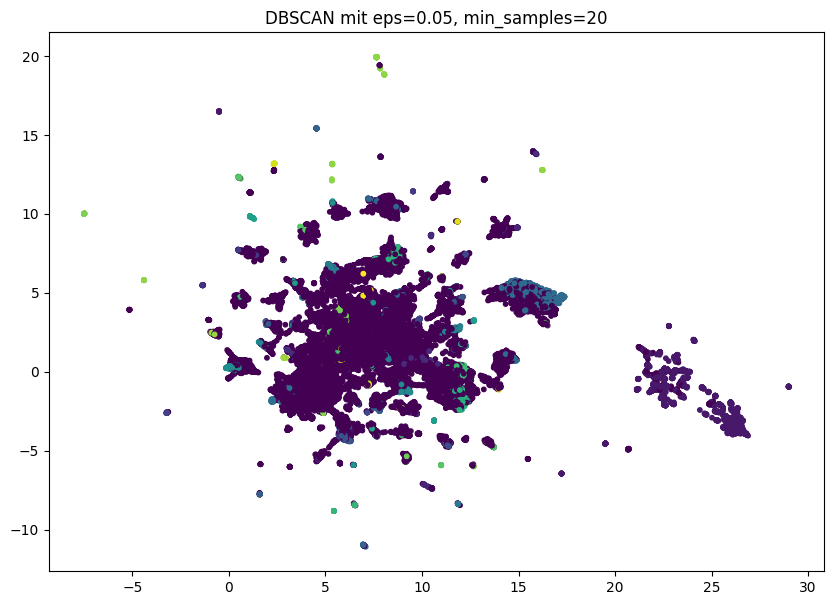

Parameter eps=0.05, min_samples=20
{-1: 39627, 0: 68, 1: 27, 2: 48, 3: 74, 4: 2481, 5: 76, 6: 70, 7: 163, 8: 172, 9: 196, 10: 63, 11: 85, 12: 113, 13: 70, 14: 242, 15: 90, 16: 37, 17: 99, 18: 226, 19: 124, 20: 73, 21: 97, 22: 147, 23: 25, 24: 308, 25: 1243, 26: 103, 27: 427, 28: 46, 29: 34, 30: 96, 31: 223, 32: 24, 33: 215, 34: 105, 35: 213, 36: 309, 37: 36, 38: 88, 39: 69, 40: 21, 41: 22, 42: 61, 43: 32, 44: 36, 45: 65, 46: 55, 47: 349, 48: 313, 49: 91, 50: 104, 51: 223, 52: 48, 53: 53, 54: 58, 55: 161, 56: 84, 57: 31, 58: 33, 59: 116, 60: 79, 61: 27, 62: 145, 63: 65, 64: 31, 65: 37, 66: 33, 67: 22, 68: 28, 69: 50, 70: 38, 71: 22, 72: 27, 73: 33, 74: 22, 75: 22}

----------------------------------------



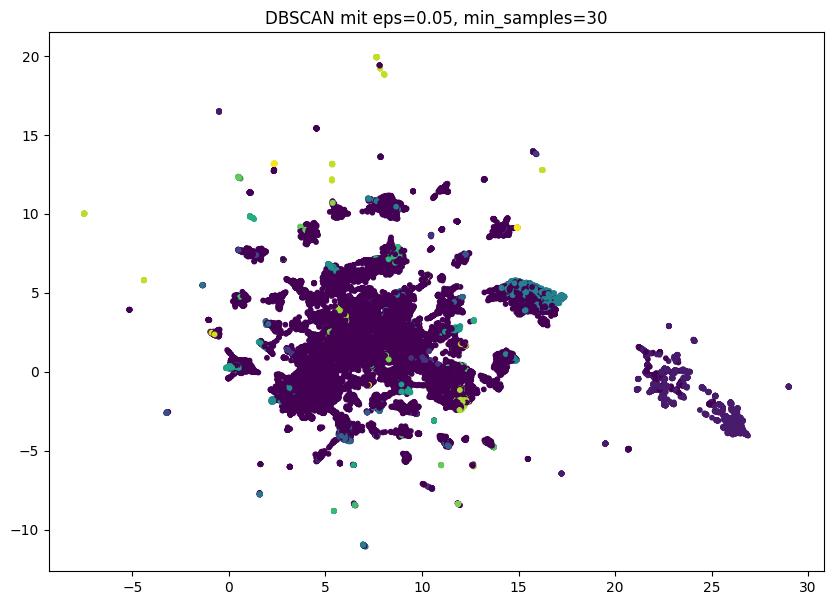

Parameter eps=0.05, min_samples=30
{-1: 40853, 0: 66, 1: 48, 2: 73, 3: 2438, 4: 74, 5: 66, 6: 124, 7: 135, 8: 194, 9: 83, 10: 77, 11: 70, 12: 227, 13: 86, 14: 36, 15: 85, 16: 213, 17: 119, 18: 70, 19: 54, 20: 85, 21: 145, 22: 306, 23: 1188, 24: 102, 25: 427, 26: 45, 27: 189, 28: 208, 29: 94, 30: 201, 31: 300, 32: 62, 33: 56, 34: 48, 35: 282, 36: 90, 37: 96, 38: 173, 39: 49, 40: 58, 41: 157, 42: 80, 43: 91, 44: 76, 45: 53, 46: 101, 47: 289, 48: 79, 49: 145, 50: 64, 51: 32, 52: 42, 53: 38, 54: 27}

----------------------------------------



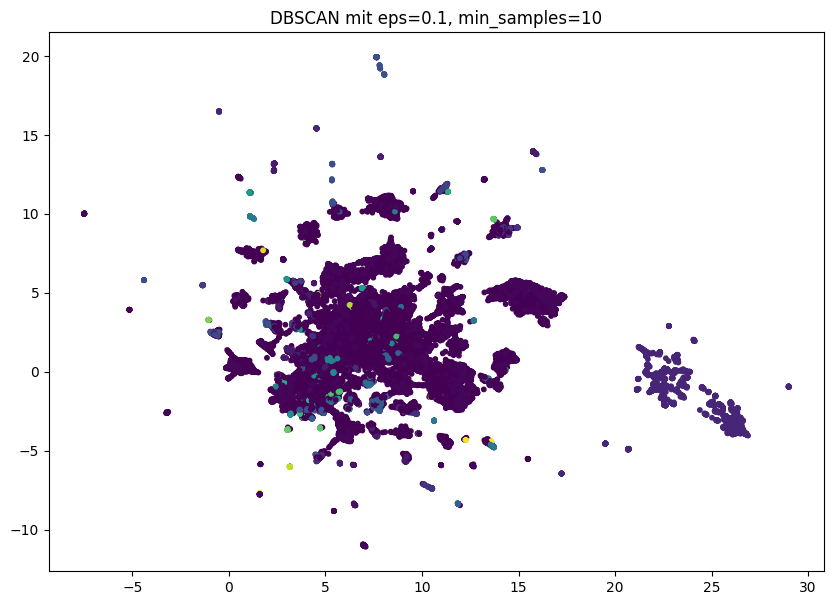

Parameter eps=0.1, min_samples=10
{-1: 25747, 0: 15878, 1: 189, 2: 288, 3: 203, 4: 295, 5: 451, 6: 345, 7: 170, 8: 2663, 9: 144, 10: 255, 11: 377, 12: 24, 13: 190, 14: 215, 15: 155, 16: 179, 17: 156, 18: 46, 19: 451, 20: 96, 21: 183, 22: 223, 23: 83, 24: 35, 25: 247, 26: 28, 27: 13, 28: 177, 29: 29, 30: 17, 31: 19, 32: 121, 33: 65, 34: 30, 35: 17, 36: 92, 37: 19, 38: 15, 39: 62, 40: 32, 41: 20, 42: 33, 43: 15, 44: 10, 45: 12, 46: 29, 47: 45, 48: 33, 49: 21, 50: 15, 51: 11, 52: 11, 53: 10, 54: 10, 55: 12, 56: 13, 57: 28, 58: 33, 59: 13, 60: 10, 61: 18, 62: 21, 63: 19, 64: 14, 65: 10, 66: 15, 67: 10, 68: 8, 69: 11, 70: 11, 71: 11, 72: 11, 73: 17, 74: 11, 75: 10, 76: 10, 77: 10, 78: 8, 79: 8, 80: 8, 81: 10, 82: 10}

----------------------------------------



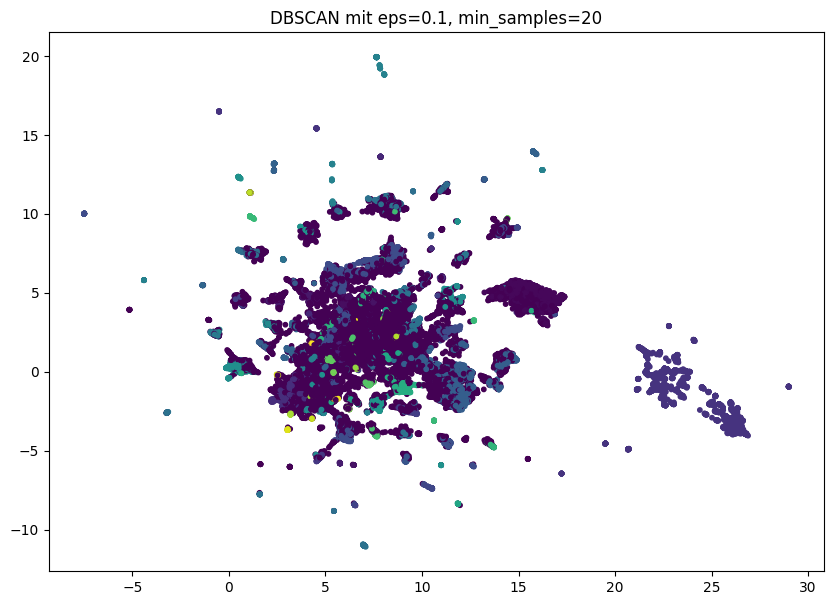

Parameter eps=0.1, min_samples=20
{-1: 28227, 0: 2129, 1: 170, 2: 198, 3: 177, 4: 179, 5: 239, 6: 169, 7: 1186, 8: 2660, 9: 133, 10: 219, 11: 270, 12: 333, 13: 3070, 14: 335, 15: 107, 16: 63, 17: 2825, 18: 434, 19: 205, 20: 148, 21: 451, 22: 1728, 23: 173, 24: 152, 25: 40, 26: 416, 27: 54, 28: 171, 29: 926, 30: 397, 31: 216, 32: 36, 33: 95, 34: 81, 35: 234, 36: 21, 37: 578, 38: 288, 39: 120, 40: 65, 41: 23, 42: 142, 43: 154, 44: 158, 45: 82, 46: 22, 47: 43, 48: 31, 49: 21, 50: 22, 51: 49, 52: 27, 53: 21, 54: 22, 55: 30, 56: 23, 57: 21, 58: 11, 59: 27, 60: 22}

----------------------------------------



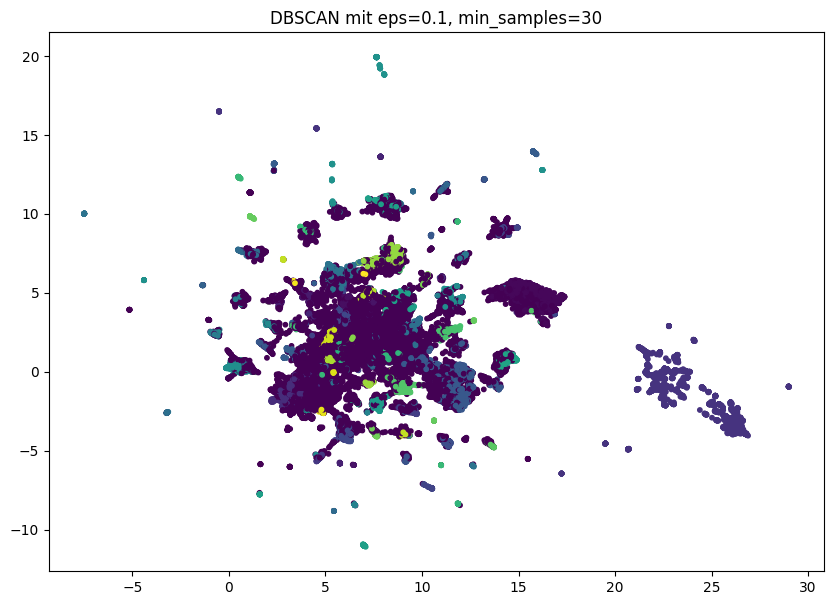

Parameter eps=0.1, min_samples=30
{-1: 29872, 0: 2080, 1: 159, 2: 191, 3: 171, 4: 153, 5: 160, 6: 1100, 7: 2660, 8: 132, 9: 214, 10: 313, 11: 737, 12: 190, 13: 100, 14: 2288, 15: 424, 16: 122, 17: 142, 18: 423, 19: 489, 20: 761, 21: 168, 22: 148, 23: 257, 24: 79, 25: 158, 26: 864, 27: 322, 28: 35, 29: 210, 30: 1003, 31: 331, 32: 85, 33: 79, 34: 216, 35: 228, 36: 395, 37: 58, 38: 404, 39: 541, 40: 116, 41: 65, 42: 137, 43: 120, 44: 142, 45: 715, 46: 146, 47: 77, 48: 150, 49: 141, 50: 219, 51: 33, 52: 53, 53: 34, 54: 59}

----------------------------------------



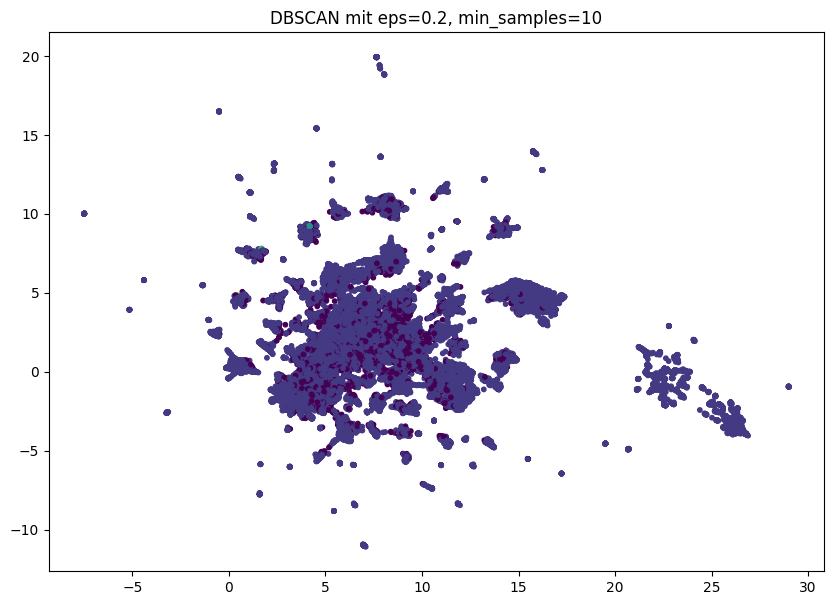

Parameter eps=0.2, min_samples=10
{-1: 5715, 0: 44907, 1: 9, 2: 10, 3: 10, 4: 12, 5: 6}

----------------------------------------



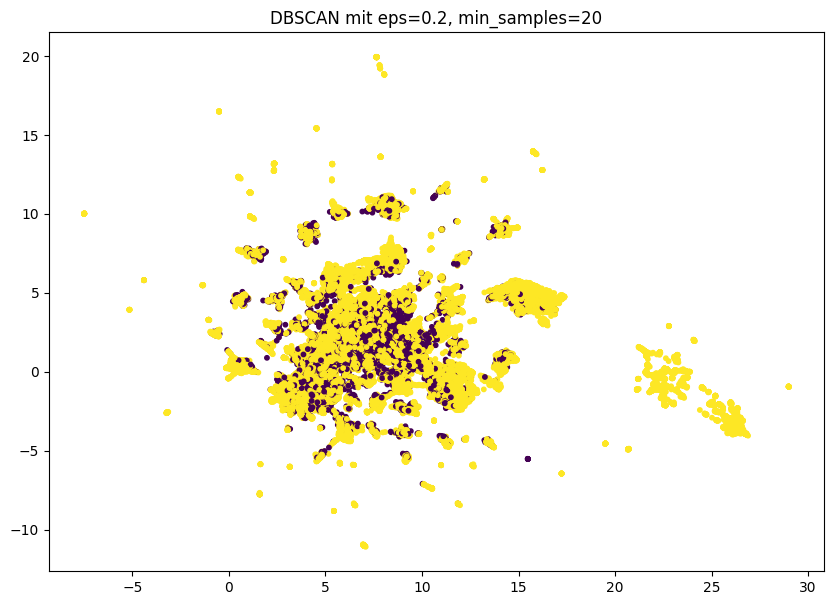

Parameter eps=0.2, min_samples=20
{-1: 7161, 0: 43508}

----------------------------------------



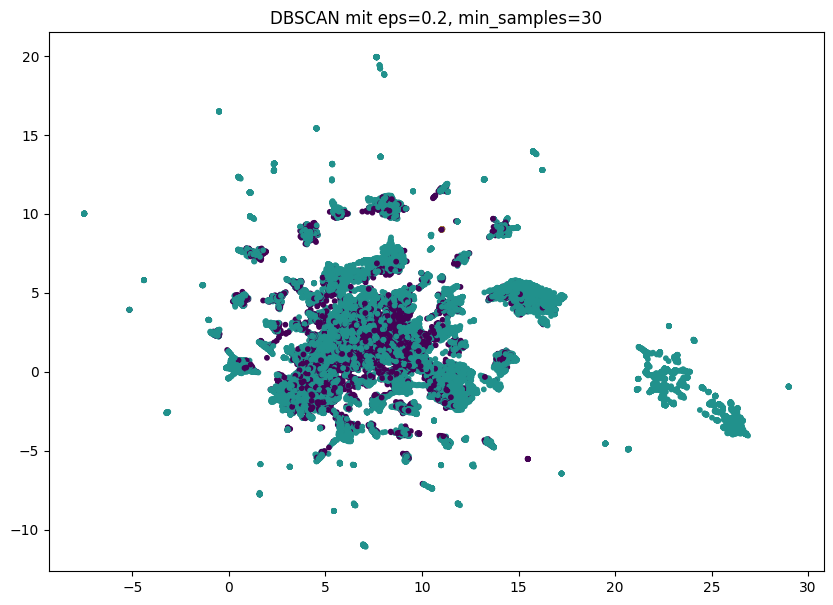

Parameter eps=0.2, min_samples=30
{-1: 8142, 0: 42499, 1: 28}

----------------------------------------



In [11]:
# DBSCAN Clustering
eps_values = [0.05, 0.1, 0.2]
min_samples_values = [1000, 2000, 3000]

# Small eps values (like 0.05) lead to many small, dense clusters and a high number of outliers, which might be too restrictive for your dataset.
# Medium eps values (e.g., 0.1) offer a better balance and create several larger clusters. This might be a better choice as it results in fewer outliers and more differentiated clusters.
# Large eps values (e.g., 0.2) tend to group most data points into one cluster, indicating that eps=0.2 is too large to form meaningful clusters.

labels = None

for eps in eps_values:
    for min_samples in min_samples_values:
        dbscan = DBSCAN(eps=eps, min_samples=min_samples, metric='cosine')
        labels = dbscan.fit_predict(reduced_features)

        plt.figure(figsize=(10, 7))
    #    plt.scatter(umap_features[:, 0], umap_features[:, 1], c=labels, cmap='viridis', s=10)
        plt.title(f'DBSCAN mit eps={eps}, min_samples={min_samples}')
        plt.show()

        unique, counts = np.unique(labels, return_counts=True)
        print(f'Parameter eps={eps}, min_samples={min_samples}')
        print(dict(zip(unique, counts)))
        print("\n" + "-"*40 + "\n")

# Elements an Categories per Clustering

In [12]:
# MiniBatchKMeans

# Count the number of articles in each cluster
cluster_counts = news['cluster'].value_counts().sort_index()

# Initialize dictionaries to store cluster information
cluster_examples = {}
cluster_categories = {}

# Iterate through each cluster
for cluster_id in sorted(news['cluster'].unique()):
    cluster_data = news[news['cluster'] == cluster_id]
    
    # Save 10 example articles (title and category)
    cluster_examples[cluster_id] = cluster_data[['title', 'category']].head(10)
    
    # Count the categories within the cluster
    cluster_categories[cluster_id] = cluster_data['category'].value_counts()

# Print the results
print("Number of articles per cluster:")
print(cluster_counts)

for cluster_id in cluster_examples:
    print(f"\nCluster {cluster_id}:")
    print("Examples:")
    print(cluster_examples[cluster_id])
    print("\nCategories in the cluster:")
    print(cluster_categories[cluster_id])


Number of articles per cluster:
cluster
0    20446
1     7269
2     2443
3     1053
4     2658
5    16800
Name: count, dtype: int64

Cluster 0:
Examples:
                                                title       category
0   The Brands Queen Elizabeth, Prince Charles, an...      lifestyle
1                       50 Worst Habits For Belly Fat         health
4   How to Get Rid of Skin Tags, According to a De...         health
6   It's been Orlando's hottest October ever so fa...        weather
10  50 Foods You Should Never Eat, According to He...         health
11  Trying to Make a Ram 3500 as Quick as a Viper ...          autos
12  25 Biggest Grocery Store Mistakes Making You G...         health
13  Instagram Filters with Plastic Surgery-Inspire...         health
16            Stars who got fired from major projects  entertainment
18                 Is This The 2021 GMC Yukon Denali?          autos

Categories in the cluster:
category
news             4677
sports           3548
financ

In [13]:
# DBSCAN

# Count the number of articles in each DBSCAN cluster
unique_labels = np.unique(labels)  # labels = DBSCAN output labels
cluster_counts_dbscan = {label: (labels == label).sum() for label in unique_labels}

# Initialize dictionaries to store cluster information
cluster_examples_dbscan = {}
cluster_categories_dbscan = {}

# Iterate through each DBSCAN cluster
for cluster_id in unique_labels:
    cluster_data = news[labels == cluster_id]
    
    # Save 10 example articles (title and category)
    cluster_examples_dbscan[cluster_id] = cluster_data[['title', 'category']].head(10)
    
    # Count the categories within the cluster
    cluster_categories_dbscan[cluster_id] = cluster_data['category'].value_counts()

# Print the results
print("Number of articles per DBSCAN cluster:")
print(cluster_counts_dbscan)

for cluster_id in cluster_examples_dbscan:
    print(f"\nCluster {cluster_id}:")
    print("Examples:")
    print(cluster_examples_dbscan[cluster_id])
    print("\nCategories in the cluster:")
    print(cluster_categories_dbscan[cluster_id])

Number of articles per DBSCAN cluster:
{-1: 8142, 0: 42499, 1: 28}

Cluster -1:
Examples:
                                                 title   category
12   25 Biggest Grocery Store Mistakes Making You G...     health
36   Extinction Rebellion wins court challenge agai...       news
40   POWER RANKING: Here's who has the best chance ...       news
60    23 Things Car Dealerships Don't Want You To Know      autos
71   Do You Hate Meditating? So Do These People, Bu...  lifestyle
76   Viral college football fan under fire for past...      video
77   Watch this priest perform a 'spirited' dance a...      video
79   All eyes on Drew Brees as possibility of retur...     sports
103  28 Surprisingly Good Costco, Walmart, and Targ...  lifestyle
120  Fall Home Maintenance Checklist: 20 Things to ...  lifestyle

Categories in the cluster:
category
sports           2502
news             2396
finance           500
travel            446
lifestyle         434
weather           363
foodanddrink   